In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# filter only test playersex
df = filter_by_id(df, player_in_test)

In [23]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = None

In [24]:
df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()

<AxesSubplot:xlabel='target_avg', ylabel='Count'>

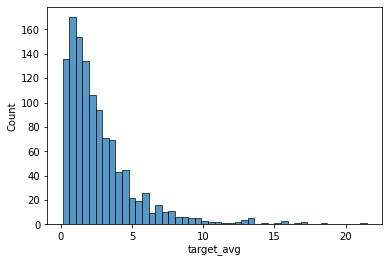

In [27]:
sns.histplot(playerList['target_avg'])

In [30]:
(playerList['target_avg'] > 5).sum()

150

In [23]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [24]:
df.playerId.nunique()

100

In [28]:
df = filter_by_id(df, [660271])

In [29]:
# player stats

In [30]:
df.head()

,playerId,target1,target2,target3,target4,date,home,pstatsDate,battingOrder__ptvf,groundOuts__ptvf,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,660271,0.0,6.225681,0.000000,31.470588,2018-01-01,NaN,NaT,NaN,NaN,...,0,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719
1,660271,0.0,3.578205,3.468022,16.180451,2018-01-02,NaN,NaT,NaN,NaN,...,1,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719
2,660271,0.0,3.617216,20.326315,22.012038,2018-01-03,NaN,NaT,NaN,NaN,...,2,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719
3,660271,0.0,4.491452,0.737624,34.008594,2018-01-04,NaN,NaT,NaN,NaN,...,3,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719
4,660271,0.0,1.650581,0.096786,12.240974,2018-01-05,NaN,NaT,NaN,NaN,...,4,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719


### preprocessing with pipelines

In [31]:
from typing import List
def forward_fill(df: pd.DataFrame, features: List[str],
                 on='playerId',
                 suffix: str = None,
                 limit: int =None):
    ffilled_df = df.groupby(on)[features].ffill(limit=limit)
    output_features = (features if suffix is None else
                       list(map(lambda f: suffix + f, features)))
    outputX = df.copy()
    outputX.loc[:, output_features] = ffilled_df.to_numpy()
    return outputX

In [32]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['pstatsTime'] = (df['date'] - pd.to_datetime(df['pstatsDate'])).dt.total_seconds()
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    df['rostersTime'] = (df['date'] - pd.to_datetime(df['rosterDate'])).dt.total_seconds()
    df[['rostersTime', 'pstatsTime']] /= 60 * 60 * 24
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
#     df['AwardWinner'] = df['awardId'].isna().astype(np.float64)
    return df

In [33]:
def fillna(df: pd.DataFrame, fill_value=0):
    return df.fillna(fill_value)

In [34]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info

In [35]:
last_ffill_features = ['gameType',
 'isTie',
 'gamesInSeries',
 'playerTeamWins',
 'playerTeamLosses',
 'playerTeamWinPct',
 'playerTeamWinner',
 'playerTeamScore',
 'opponentTeamWins',
 'opponentTeamLosses',
 'opponentTeamWinPct',
 'opponentTeamScore',
 'teamScoreDiff',
 'opponentTeamId']
                          
                          
inplace_ffill_features = ['numberOfFollowers',
                          'teamFollowers',
                          'status',
                          'teamId',
                          'rosterDate',
                          'pstatsDate']

In [36]:
# transformer for filling nan values with past valid values
# transformer for generating some hardcoded features
inplace_fill_forward_tmf = FunctionTransformer(forward_fill,
                                               kw_args={'features': inplace_ffill_features,
                                                        'on': ['playerId', 'year']})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [37]:
# creating pipeline
ffill_and_gen_harcoded_feat = Pipeline([('inplace_fill_forward', inplace_fill_forward_tmf),
                                        ('hardcoded_feat', harcoded_feat_tmf)])

In [38]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [39]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year', 'primaryPositionName',
              'status', 'teamId', 'weekday',
              'opponentTeamId', 'home', 'seriesDescription', 'currentGameInSeries']

In [40]:
categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [41]:
from sklearn.preprocessing import KBinsDiscretizer

class PdKBinsDiscretizer(KBinsDiscretizer):
    def __init__(self, n_bins=5,
                 encode: str = 'ordinal',
                 strategy: str ='quantile'):
        super().__init__(n_bins=n_bins,
                 encode=encode,
                 strategy=strategy)
        
    def transform(self, X: pd.DataFrame):
        features = list(X.columns)
        outputX = super().transform(X).astype(np.int64)
        return pd.DataFrame(outputX, columns=features)

In [42]:
# for the statistics, we will compute them and then resuse them
stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[30], drop_index=False)
target_stats_tmf = PdColumnTransformer([('gen_stats', stats_gen_tmf, pp_cols)])
target_stats_table = target_stats_tmf.fit_transform(df)


target_stats_table.head()

,playerId,date,target1__mean__30d,target1__median__30d,target1__std__30d,target2__mean__30d,target2__median__30d,target2__std__30d,target3__mean__30d,target3__median__30d,target3__std__30d,target4__mean__30d,target4__median__30d,target4__std__30d
0,660271,2018-01-01,0.0,0.0,NaN,6.225681,6.225681,NaN,0.000000,0.000000,NaN,31.470589,31.470589,NaN
1,660271,2018-01-02,0.0,0.0,0.0,4.901943,4.901943,1.872048,1.734011,1.734011,2.452262,23.825520,23.825520,10.811760
2,660271,2018-01-03,0.0,0.0,0.0,4.473701,3.617216,1.517385,7.931446,3.468022,10.873425,23.221025,22.012037,7.716431
3,660271,2018-01-04,0.0,0.0,0.0,4.478138,4.054334,1.238971,6.132990,2.102823,9.579076,25.917917,26.741314,8.293880
4,660271,2018-01-05,0.0,0.0,0.0,3.912627,3.617216,1.658404,4.925750,0.737624,8.723886,23.182529,22.012037,9.434145


In [43]:
## merge computed statistics
reuse_computed_stats = Pipeline([('merge_stats', FeaturesTable(target_stats_table, lags=[45], clip_max=True)),
                                 ('fillnan', FunctionTransformer(fillna)),
                                 ('normalize', PdScaleNorm())
                                ])

In [44]:
# for continuous features, we will filter them and then fill nan values and normalize them

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures(ignore_features=categories +
                                                                           pp_cols +
                                                                           ['target_avg'])),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [45]:
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List
class FilterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, suffixes: List[str]):
        self.suffixes = suffixes
    
    def fit(self, X: pd.DataFrame, y=None):
        self._features = list(filter(lambda f: any([f.endswith(suffix) for suffix in self.suffixes]),
                                     X.columns))
        return self
    
    def transform(self, X: pd.DataFrame):
        return X.loc[:, self._features]

In [46]:
player_tv_cont_features = FilterFeatures(['runsScored__ptvf', 'homeRuns__ptvf',
                                          'hits__ptvf', 'SLG__ptvf',
                                          'rbi__ptvf',
                                          'plateAppearances__ptvf',
                                          'runsPitching__ptvf',
                                           'playerId', 'date']).fit(df)._features

In [47]:
player_tv_cont_features

['playerId',
 'date',
 'runsScored__ptvf',
 'homeRuns__ptvf',
 'hits__ptvf',
 'plateAppearances__ptvf',
 'rbi__ptvf',
 'runsPitching__ptvf',
 'SLG__ptvf']

In [48]:
## moving stats for players stats
# get the rest of the continuous features
stats_gen_cont_features = StatisticGen(stats=['sum', 'max'],
                             windows=[7],
                             drop_index=True)
_mov_cont_feat_tmf = Pipeline([('fillnan', FunctionTransformer(fillna)),
                               ('cont_stats', stats_gen_cont_features),
                                ('normalize', PdScaleNorm()),
                                ])
mov_cont_feat_tmf = PdColumnTransformer([('cont', _mov_cont_feat_tmf, player_tv_cont_features)]
                                 )

In [49]:
# putting all features generation steps together
all_features_tmf = PdFeatureUnion([('stats', reuse_computed_stats), 
                                   ('cont_feat', continuous_feat_tmf), 
                                   ('cats', categories_tmf),
                                   ('mov_feat', mov_cont_feat_tmf),
                                  ])

In [50]:
# main pipeline with all steps 
pipeline = Pipeline([('core_features', ffill_and_gen_harcoded_feat),
                     ('features_generation', all_features_tmf)])

In [51]:
pipeline

Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fb521bf3940>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate'],
                                                               'on': ['playerId',
                                                                      'year']})),
                                 ('hardcoded_feat',
                                  FunctionTrans

In [52]:
from data.split import SplitData

In [53]:
# split the data on 2021-03-01 with a valid ds of 61 days
sp = SplitData("2021-04-01", test_days=500)

In [54]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [55]:
%%time
# train the pipeline only with the train dataset
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 88.9 ms, sys: 0 ns, total: 88.9 ms
Wall time: 90.6 ms


Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fb521bf3940>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate'],
                                                               'on': ['playerId',
                                                                      'year']})),
                                 ('hardcoded_feat',
                                  FunctionTrans

In [56]:
def add_noise(df: pd.DataFrame, features,
              on):
    noise_std = df.groupby(['playerId'])[features].transform('std')
    noisy_features = (np.random.randn(*noise_std.shape) * noise_std).to_numpy().astype(np.float32)
    
    return noisy_features

In [57]:
# noise_df = df.copy()

In [58]:
# noise_df.loc[train_idx, target_cols] += add_noise(noise_df.loc[train_idx, :],
#                                            features=target_cols, on=['playerId'])

In [59]:
# noise_df.loc[train_idx, target_cols] = np.clip(noise_df.loc[train_idx, target_cols], 0, 100)

In [60]:
%%time
# transform all dataset
features = pipeline.transform(df)

CPU times: user 90.2 ms, sys: 1.07 ms, total: 91.3 ms
Wall time: 88.6 ms


In [61]:
pd.options.display.max_rows = len(features.columns)
features.T.head(len(features.columns))

,0,1,2,3,4,5,6,7,8,9,...,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293
target1__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.820905,0.848780,0.796853,0.798415,0.820287,0.826176,0.815949,0.809351,0.754999,0.713906
target1__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.667721,0.667721,0.612123,0.612123,0.667721,0.667721,0.667721,0.667721,0.584707,0.516380
target1__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797779,0.843471,0.839874,0.838407,0.836331,0.831561,0.839999,0.846375,0.842546,0.845276
target2__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.784190,0.784190,0.774561,0.789038,0.805830,0.811152,0.806350,0.799072,0.788956,0.771019
target2__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.774071,0.774071,0.738619,0.754111,0.789563,0.789563,0.789563,0.789563,0.789563,0.754111
target2__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.810027,0.810027,0.793307,0.776808,0.763935,0.749082,0.763025,0.788078,0.806044,0.805546
target3__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.756508,0.724409,0.685927,0.713581,0.735025,0.726161,0.722636,0.717958,0.659411,0.613281
target3__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.586651,0.586651,0.586651,0.651896,0.651896,0.651896,0.651896,0.651896,0.586651,0.526057
target3__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.934711,0.889887,0.839226,0.832025,0.873986,0.886022,0.891181,0.898234,0.865078,0.847330
target4__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.725811,0.730226,0.688669,0.681595,0.689819,0.677361,0.688826,0.690212,0.682399,0.675653


In [62]:
# change the dtypes of the target (pytorch likes float32 and not float64)
df[target_cols] = df[target_cols].astype(np.float32)

In [63]:
train_idx.shape

(1294,)

In [64]:
train_idx.shape

(1294,)

In [65]:
train_data = sp.filter(features, train_idx)

raw_train_df = sp.filter(df, train_idx)

In [66]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [67]:
train_data.shape, raw_train_df.shape

((1186, 132), (1186, 114))

In [68]:
valid_data.shape, raw_valid_df.shape

((108, 132), (108, 114))

In [69]:
# add the target to features ds
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [70]:
target_features = list(features.columns[features.columns.str.startswith('target')])

In [71]:
new_categories = categories #+ #target_features

In [72]:
cont_features = features.columns.drop(new_categories).to_list()

In [73]:
new_categories

['playerId',
 'seasonPart',
 'year',
 'primaryPositionName',
 'status',
 'teamId',
 'weekday',
 'opponentTeamId',
 'home',
 'seriesDescription',
 'currentGameInSeries']

In [74]:
from torch.utils.data import DataLoader
import torch
from typing import Dict, List
import numpy as np
import pandas as pd
import gc


def get_timeseries_index(values: np.ndarray,
                         idx: int,
                         bptt: int):

    start_idx = max(0, idx - bptt)
    timeft = values[start_idx: idx + 1]
    
    if len(timeft) <= bptt:
        missing_steps = bptt - len(timeft) + 1
        timeft = np.pad(timeft, pad_width=((missing_steps, 0), (0, 0)))

    return timeft



class PlayerDataset:
    def __init__(self, features: np.ndarray,
                 categories: np.ndarray,
                 target: np.ndarray = None,
                 bptt: int = 10,
                 device: torch.device = torch.device('cpu')):
        self.features = features
        self.target = target
        self.bptt = bptt - 1
        self.device = device
        self.categories = categories
        assert len(self) > self.bptt, f'lenght: {len(self)}, bptts: {self.bptt}'

    def __len__(self):
        return len(self.features)

    def _to_torch(self, array):
        return torch.from_numpy(np.asarray(array)).to(device=self.device)
    
    def to_device(self, batch_item: Dict[str, np.ndarray]):
        return {name: self._to_torch(values)
                for name, values in batch_item.items()}
    
    def __getitem__(self, idx: int):        
        features = (get_timeseries_index(self.features, idx=idx,
                                         bptt=self.bptt)
                    if self.bptt > 0 else self.features[idx])
        cats = (get_timeseries_index(self.categories, idx=idx,
                                         bptt=self.bptt)
                    if self.bptt > 0 else self.categories[idx])

        batch_item = {'features': features,
                      'categories': cats}
        if self.target is not None:
            batch_item['target'] = self.target[idx]
    
        return self.to_device(batch_item)

    @classmethod
    def from_df(cls, df: pd.DataFrame,
                features: List[str],
                categories: List[str],
                target: List[str]=None,
                bptt: int = 30,
                device: torch.device = torch.device('cpu')):

        if target is not None:
            target = df.loc[:, target].to_numpy()
    
        return cls(features=df.loc[:, features].to_numpy(),
                categories=df.loc[:, categories].to_numpy(),
                target=target,
                bptt=bptt,
                device=device)

    def __del__(self):
        del self.features, self.target, self.categories
        gc.collect()

In [75]:
import pytorch_lightning as pl
from typing import List, Tuple, Callable, Dict
from torch import nn, optim
from torch.nn import functional as F
import torch
from einops import rearrange
from collections import OrderedDict

def mae(yhat, y):
    return torch.abs(yhat-y).mean()

def log_mae(yhat, y):
    def to_log(x):
        return torch.log(x + 1)
    return mae(yhat, to_log(y))


def build_feed_forward(layers: List[int],
                       use_bn: bool = False,
                       input_bn: bool = False,
                       act_fn: Callable = nn.ReLU,
                       dropout: List[int] = None):
    model = []

    if input_bn:
        model.append(nn.BatchNorm1d(layers[0]))

    if isinstance(dropout, float):
        dropout = [dropout] * len(layers)

    for L in range(len(layers)-1):
        input_dim, output_dim = layers[L], layers[L+1]
        linear = nn.Linear(input_dim, output_dim)
        model.append(linear)
        if L+1 < len(layers) -1:
            model.append(act_fn())
            if use_bn:
                model.append(nn.BatchNorm1d(output_dim))
            if dropout is not None:
                model.append(nn.Dropout(dropout[L]))

    return nn.Sequential(*model)

from models.lstm import EmbeddingLayer
def dropout_mask(x, shape, p):
    return x.new(*shape).bernoulli_(1-p).div_(1-p)

def ts_dropout_mask(x: torch.tensor, 
                           p: float,
                           training: bool = True):
    bs, sq, f = x.size()
    if (p <= 0.) or (not training):
        return x
    mask = dropout_mask(x, (1, sq, 1), p)
    return mask * x

class TimeSeriesDropout(nn.Module):
    def __init__(self, p: float = 0.):
        super().__init__()
        self.p = p
        
    def forward(self, x: torch.tensor):
        return ts_dropout_mask(x, p=self.p, training=self.training)


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [76]:
def compute_factor_layers(input_dim,
                          depth: int = 1,
                          factor: float = 1.,
                          dtype=np.int64):
    layers_sizes = np.array([input_dim] * (depth-1))
    layers_pct = np.array([[factor] * (depth-1)])
    layers_pct = np.cumprod(layers_pct)
    layers_sizes = list((layers_sizes * layers_pct).astype(dtype))
    return layers_sizes

In [77]:
from models.lstm import mae
from models.lstm import EmbeddingLayer

class EmbModel(pl.LightningModule):
    def __init__(self, 
                 cont_features: int,
                 categories: Dict[str, int],
                 encoder_dim: int,
                 depth: int,
                 decrease_factor: float = 1.,
                 drop_decrease_factor: float = 1.,
                 emb_dropout: float = 0.,
                 max_emb_sz: int = 20,
                 dropout: float = 0.,
                 lr: float = 0.01,
                 wd: float = 0.,
                 out_features: int = 1):
        super().__init__()
        
        self.lr = lr
        self.wd = wd

        
        self.emb = EmbeddingLayer(categories, dropout=emb_dropout, max_emb_sz=max_emb_sz)
        
        
        layers_sizes = compute_factor_layers(encoder_dim, depth=depth, factor=decrease_factor)
        drop_sizes = compute_factor_layers(dropout, depth=depth,
                                           factor=drop_decrease_factor, dtype=float)
        daily_features = self.emb.out_features + cont_features
        
        dropout_layers = [dropout] + drop_sizes
        
        
        daily_decoder_layers = [daily_features, encoder_dim] + layers_sizes + [out_features]
        self.output_layer = build_feed_forward(daily_decoder_layers, use_bn=False,
                                                dropout=dropout_layers,
                                                act_fn=self._act_fn)
        
    def _act_fn(self):
        return nn.LeakyReLU(0.2)

    def forward(self, features,
                categories,
                target=None):        

        categories = self.emb(categories)

        features = torch.cat((features, categories), dim=-1)
        
        prediction = self.output_layer(features)
        # scaled prediction to 0 to 100
        prediction = torch.sigmoid(prediction) * 100

        return prediction
    
    def training_step(self, batch, batch_idx):
        y_hat = self(**batch)
        loss = mae(y_hat, batch['target'])
        self.log('train_mae', loss, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(**batch)
        loss = mae(y_hat, batch['target'])
        self.log('valid_mae', loss, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
#                                            patience=3)
        return optimizer

In [78]:

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import pytorch_lightning as pl
from typing import Dict, Any
import torch
from torch.utils.data import DataLoader
from torch import nn
import pandas as pd
import gc
# from models.lstm import LstmModel ###no
# from data.dataset import PlayerDataset ###no
from train.core import ModelOutput ###no


def get_emb_size(cardinality: int, maximum: int = 20):
    return (cardinality+1, min(cardinality//2, 20))

def predict_dl(model: nn.Module, valid_dl: DataLoader):
    model.eval()
    with torch.no_grad():
        
        prediction = torch.cat([model(**batch)
                               for batch in valid_dl])
    return prediction.numpy()


def load_best_state(model, checkpoint_callback):
    print('loading model to best score')
    print(f'best score = {checkpoint_callback.best_model_score}')
    best_model_parameters = torch.load(checkpoint_callback.best_model_path)['state_dict']
    model.load_state_dict(best_model_parameters)
    return model
    


def run_fn(config: Dict[str, Any],
             train_data: pd.DataFrame,
             valid_data: pd.DataFrame):
    
    if config.seed is not None:
        torch.manual_seed(config.seed)

    # hyperparameters
    hp = config.hp
    
    # create dls
    train_ds = PlayerDataset.from_df(train_data,
                                      features=config.features,
                                      categories=config.categories,
                                      target=config.target_cols,
                                      bptt=hp.bptt)

    train_dl = DataLoader(train_ds, batch_size=hp.batch_size, shuffle=True,
                          num_workers=4)

    valid_ds = PlayerDataset.from_df(valid_data, 
                                      features=config.features,
                                      categories=config.categories,
                                      target=config.target_cols,
                                      bptt=hp.bptt)
    valid_dl = DataLoader(valid_ds, batch_size=hp.batch_size,
                          shuffle=False, num_workers=4)
    
    
    categories = train_data.loc[:, config.categories].nunique().to_dict()
    
    model = EmbModel(cont_features=len(config.features),
                      categories=categories,
                      max_emb_sz=hp.max_emb_sz,
                      encoder_dim=hp.encoder_dim,
                      out_features=len(config.target_cols),
                      dropout=hp.dropout,
                      emb_dropout=hp.emb_dropout,
                      depth=hp.depth,
                      lr=hp.lr,
                      decrease_factor=hp.decrease_factor,
                      drop_decrease_factor=hp.drop_decrease_factor,
                      wd=hp.wd)
    print(model)
    # return model, valid_dl    
    early_stopping = EarlyStopping('valid_mae', patience=3)
    checkpoint_callback  = ModelCheckpoint(monitor='valid_mae',
                                           save_top_k=3,
                                           save_weights_only=True)
    trainer = pl.Trainer(max_epochs=hp.epochs,
                         callbacks=[early_stopping, checkpoint_callback])

    trainer.fit(model, train_dl, valid_dl)

    # loading best model so far
    model = load_best_state(model, checkpoint_callback)
    
    def predict_fn(test_features: pd.DataFrame):
        test_ds = PlayerDataset.from_df(test_features,
                                        features=config.features,
                                        categories=config.categories,
                                        bptt=hp.bptt)
        test_dl = DataLoader(test_ds, batch_size=hp.batch_size, shuffle=False)
        prediction = predict_dl(model, test_dl)
        del test_dl, test_ds
        return prediction

    valid_prediction = predict_dl(model, valid_dl)
    gc.collect()
    return ModelOutput(model, predict_fn, valid_prediction)

In [84]:
from omegaconf import OmegaConf
hp = {'bptt': 1,
      'epochs': 10,
      'batch_size': 512,
      'max_emb_sz': 20,
      'hidden_dim': 16,
      'encoder_dim': 512,
      'depth': 2,
      'emb_dropout': 0.2,
      'dropout': 0.5,
      'decrease_factor': 0.5,
      'drop_decrease_factor': 1.,
      'lr': 0.001,
      'wd': 3e-5}

real_data_config = {'hp': hp,
                    'seed': 2021,
         'features': cont_features,
          'categories': new_categories,
          'target_cols': target_cols}
real_data_config = OmegaConf.create(real_data_config)

In [85]:
target_features = [f for f in train_data.columns
                   if f.startswith('target') and f not in target_cols]

In [86]:
output = []

In [87]:
# from copy import deepcopy
# for target_name in target_cols:
#     target_config = deepcopy(real_data_config)
#     target_config['target_cols'] = [target_name]
#     target_output = run_fn(target_config, train_data, valid_data)
#     output.append(target_output)

In [94]:
output = run_fn(real_data_config, train_data, valid_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 168   
1 | output_layer | Sequential     | 204 K 
------------------------------------------------
204 K     Trainable params
0         Non-trainable params
204 K     Total params
0.817     Total estimated model params size (MB)


EmbModel(
  (emb): EmbeddingLayer(
    (dropout): Dropout(p=0.2, inplace=False)
    (emb): ModuleDict(
      (playerId): Embedding(2, 1)
      (seasonPart): Embedding(8, 2)
      (year): Embedding(5, 2)
      (primaryPositionName): Embedding(2, 1)
      (status): Embedding(4, 1)
      (teamId): Embedding(3, 1)
      (weekday): Embedding(8, 2)
      (opponentTeamId): Embedding(24, 4)
      (home): Embedding(4, 1)
      (seriesDescription): Embedding(3, 1)
      (currentGameInSeries): Embedding(6, 2)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=139, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

loading model to best score
best score = 33.696590423583984


In [95]:
from train.core import Ensemble, predict_recursive
ensemble = Ensemble([output], pipeline)

In [96]:
# %%time
# raw_train_fr = raw_train_df[df.columns].copy()

# recursive_prediction = []
# for date, val_date_df in raw_valid_df.groupby('date'):
#     val_date_df = val_date_df[df.columns].reset_index(drop=True)
#     _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
#                                                      raw_train_fr,
#                                                      ensemble,
#                                                      n_days=90 + 60 + 10,
#                                                      target_cols=target_cols)
#     recursive_prediction.append(_recurive_pred)

# recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
# recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
# recursive_prediction.reset_index(drop=True, inplace=True)
# recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
#                                      for f in target_cols}, inplace=True)
# recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

In [98]:
from evaluate.metrics import compute_metrics

In [99]:
# prediction = np.concatenate([_out.prediction for _out in output], axis=1)
prediction = output.prediction

In [100]:
valid_test_prediction = pd.DataFrame(prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]
recursive_prediction=valid_test_prediction

In [101]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 33.69659,
 'mae_1': 31.026134,
 'mae_2': 35.89179,
 'mae_3': 35.131207,
 'mae_4': 32.73723}

In [102]:
(valid_test_prediction.groupby(valid_test_prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,26.100124,28.567705,20.811749,31.004736,24.016300
5,30.075026,29.920309,37.253365,28.127670,24.998758
6,35.312626,29.811764,40.176476,37.748470,33.513790
7,50.854332,39.524078,52.459549,50.565674,60.868019


In [103]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 33.69659,
 'mae_1': 31.026134,
 'mae_2': 35.89179,
 'mae_3': 35.131207,
 'mae_4': 32.73723}

In [104]:
april_set = valid_test_prediction[valid_test_prediction['date'].between('2021-04-01', '2021-04-30')]

In [105]:
(april_set.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,26.100124,28.567705,20.811749,31.004736,24.0163


In [106]:
(april_set.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,26.100124,28.567705,20.811749,31.004736,24.0163


In [107]:
(valid_test_prediction.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,33.69659,31.026134,35.891788,35.131207,32.737228


In [108]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(recursive_prediction)

In [109]:
# # metrics from 2021-03-01 up to 2021-03-31
# compute_metrics(valid_rc_prediction)

In [110]:
# # metrics from 2021-04-01 up to 2021-04-30
# compute_metrics(test_rc_prediction)

In [111]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

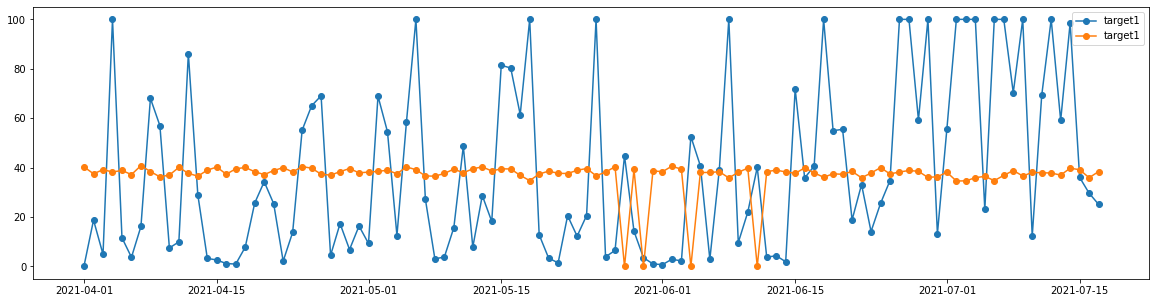

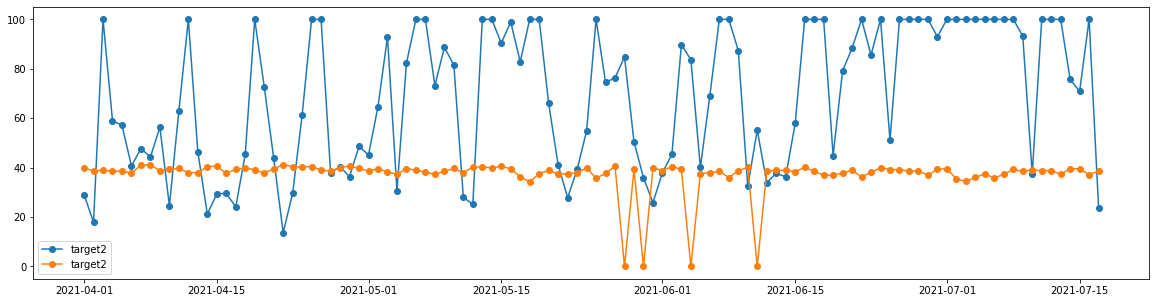

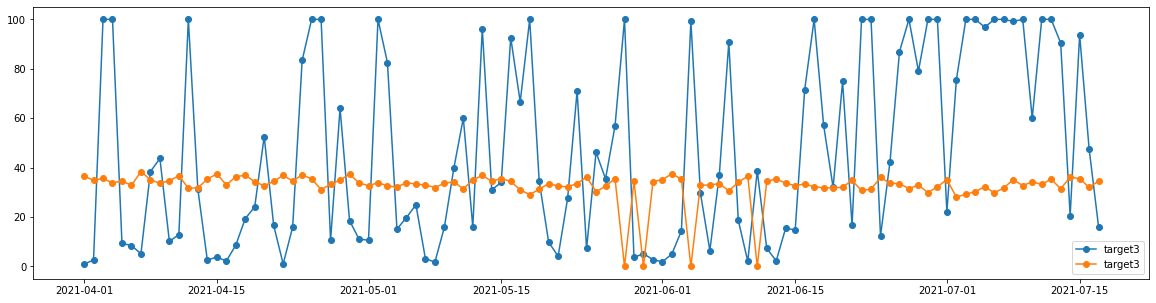

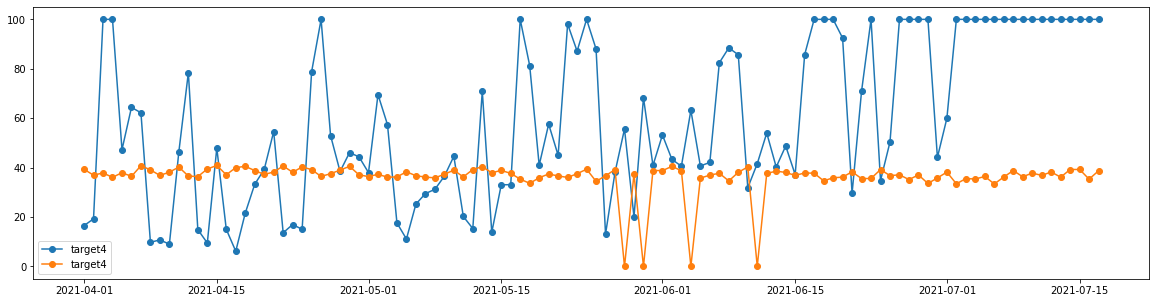

In [112]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

In [113]:
import numpy as np
import pandas as pd


def permutation_importance(predict_fn, data,
                           features,
                           target,
                           score_func,
                           times: int = 1):

    def _score(data):
        _prediction = predict_fn(data)
        prediction = data[target].copy()
        prediction[['yhat1', 'yhat2', 'yhat3', 'yhat4']] = _prediction
        error = score_func(prediction)
        return error['mae_mean']

    base_score = _score(data)
    fi = []

    for feature in features:
        permuted_data = data.copy()
        permuted_data[feature] = np.random.permutation(permuted_data[feature])
        feature_score = _score(permuted_data)
        feature_importance = {'feature': feature,
                              'score': feature_score,
                              'importance': feature_score-base_score,
                              }
        fi.append(feature_importance)
    fi = pd.DataFrame(fi)
    fi['importance'] *= 100
    fi.sort_values(by='importance', inplace=True, ascending=False)
    fi.reset_index(drop=True, inplace=True)
    return fi

In [114]:
fi_data = valid_data

In [115]:
fi_data = train_data.sample(frac=0.2).reset_index(drop=True)

In [116]:
all_features_list = list(features.columns)

In [117]:
%%time
fi_reg = permutation_importance(output.predict_fn, valid_data, 
                                all_features_list, target=target_cols, 
                                score_func=compute_metrics,
                                times=5)

CPU times: user 36.2 s, sys: 1.17 s, total: 37.3 s
Wall time: 9.34 s


In [118]:
fi_reg

,feature,score,importance
0,weekday,33.734062,3.747167
1,homeRuns__date__maxNorm__ptvf,33.719723,2.313270
2,opponentTeamWinPctAsHome,33.712784,1.619320
3,rbi__ptvf__max__7d,33.709392,1.280121
4,opponentTeamoutsPitching,33.707298,1.070678
5,currentGameInSeries,33.706265,0.967423
6,playerTeamLasttenlosses,33.705326,0.873551
7,target3__mean__30d__45lag,33.705312,0.872162
8,inningsPitched__ptvf,33.704803,0.821186
9,rbi__date__maxNorm__ptvf,33.704624,0.803333


In [103]:
valid_data['raw_playerId'] = raw_valid_df['playerId']

ValueError: x and y must have same first dimension, but have shapes (108,) and (1,)

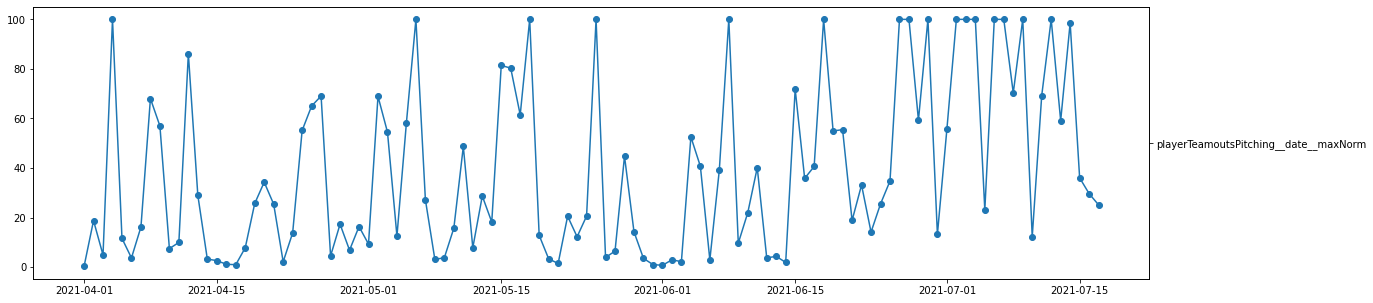

In [104]:
for index in range(1, 5):
    plot_feature_vs_target(valid_data, 'playerTeamoutsPitching__date__maxNorm', playerId=660271, index=index)